In [ ]:
# !pip install opencv-python-headless numpy

In [ ]:
# !sudo apt install tesseract-ocr
# !pip install pytesseract

In [2]:
import cv2
import re
import numpy as np
import pytesseract
from PIL import Image

def recognize_digit(cell):

    custom_config = r'--oem 3 --psm 6 outputbase digits'
    text = pytesseract.image_to_string(cell, config= custom_config)
    text = re.sub(r'\D', '', text)
    if text == '':
        return '.'
    return  text


In [75]:
import cv2
import numpy as np

def preprocess_image(image_path):
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    blurred = cv2.GaussianBlur(image, (5, 5), 0)
    thresh = cv2.adaptiveThreshold(blurred, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
                                   cv2.THRESH_BINARY_INV, 11, 2)
    return thresh

def find_largest_contour(image):
    contours, _ = cv2.findContours(image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    largest_contour = max(contours, key=cv2.contourArea)
    return largest_contour

def extract_sudoku_grid(image, contour):
    # Approximating the contour to a polygon
    epsilon = 0.1 * cv2.arcLength(contour, True)
    approx = cv2.approxPolyDP(contour, epsilon, True)

    # Ensuring that we have obtained four points
    if len(approx) != 4:
        raise ValueError("Contour does not have 4 points, cannot determine grid.")

    # Reformatting the points and sorting them in order (top-left, top-right, bottom-right, bottom-left)
    points = np.vstack(approx).squeeze()
    points = sorted(points, key=lambda x: (x[1], x[0]))  # Sort by y, then by x

    # Distinguishing between top and bottom points
    if points[0][0] > points[1][0]:
        points[0], points[1] = points[1], points[0]
    if points[2][0] < points[3][0]:
        points[2], points[3] = points[3], points[2]

    # Set the new width and height to 800
    maxWidth = maxHeight = 800

    # Destination points for the "birds eye view"
    dst = np.array([
        [0, 0],
        [maxWidth - 1, 0],
        [maxWidth - 1, maxHeight - 1],
        [0, maxHeight - 1]], dtype="float32")

    # Compute the perspective transform matrix and then apply it
    M = cv2.getPerspectiveTransform(np.array(points).astype('float32'), dst)
    warped = cv2.warpPerspective(image, M, (maxWidth, maxHeight))

    # Return the warped image
    return warped

def split_into_cells(grid):
    cells = []
    cell_size = grid.shape[0] // 9
    for y in range(9):
        row = []
        for x in range(9):
            cell = grid[y*cell_size:(y+1)*cell_size, x*cell_size:(x+1)*cell_size]
            row.append(cell)
        cells.append(row)
    return cells

def recognize_digits(cells):
    sudoku = []
    for row in cells:
        sudoku_row = []
        for cell in row:
            h, w = cell.shape
            h5 = int(h*10/100.0)
            h95 = int(h * 90/100.0)
            cell = cell[h5:h95, h5:h95]
            digit = recognize_digit(255 - cell)  # Implement digit recognition here
            sudoku_row.append(digit)
        sudoku.append(sudoku_row)
    return sudoku

# Example usage
image_path = 'fg.png'
processed_image = preprocess_image(image_path)
largest_contour = find_largest_contour(processed_image)
sudoku_grid = extract_sudoku_grid(processed_image, largest_contour)
cells = split_into_cells(sudoku_grid)
sudoku_puzzle = recognize_digits(cells)


In [76]:
sudoku_puzzle

[['2', '.', '.', '.', '.', '.', '5', '.', '.'],
 ['.', '3', '8', '.', '2', '7', '.', '.', '.'],
 ['9', '6', '.', '.', '.', '.', '.', '.', '3'],
 ['.', '.', '.', '.', '7', '.', '6', '.', '.'],
 ['.', '.', '1', '.', '.', '.', '.', '9', '4'],
 ['.', '9', '.', '1', '.', '.', '.', '.', '7'],
 ['4', '.', '.', '.', '.', '3', '.', '1', '.'],
 ['.', '7', '.', '5', '.', '2', '.', '.', '.'],
 ['.', '.', '.', '7', '4', '.', '3', '.', '.']]

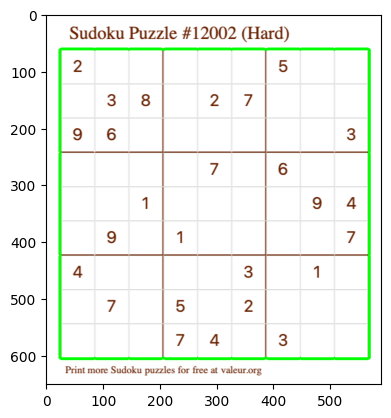

In [77]:
import cv2
import numpy as np
import matplotlib.pyplot as plt


def draw_largest_contour(original_image, processed_image):
    # Find contours in the processed image
    contours, _ = cv2.findContours(processed_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Check if any contours are found
    if not contours:
        return original_image

    # Find the largest contour
    largest_contour = max(contours, key=cv2.contourArea)

    # Draw the largest contour on the original image
    cv2.drawContours(original_image, [largest_contour], -1, (0, 255, 0), 3)

    return original_image

# Example usage
original_image = cv2.imread(image_path)
processed_image = preprocess_image(image_path)  # Assuming preprocess_image is defined as before

result_image = draw_largest_contour(original_image, processed_image)

# Display the result image or save it
plt.imshow(result_image);


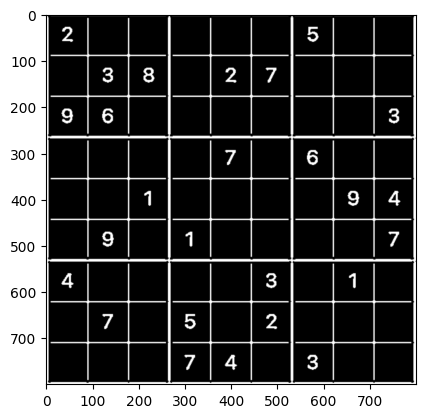

In [78]:
plt.imshow(sudoku_grid, cmap = 'gray');

In [84]:
grid = ''
for i in sudoku_puzzle:
    for j in i:
        grid += j

grid

'2.....5...38.27...96......3....7.6....1....94.9.1....74....3.1..7.5.2......74.3..'

In [81]:
len(grid)

81

In [87]:
!python solution.py

2 6 7 |9 4 5 |3 8 1 
8 5 3 |7 1 6 |2 4 9 
4 9 1 |8 2 3 |5 7 6 
------+------+------
5 7 6 |4 3 8 |1 9 2 
3 8 4 |1 9 2 |6 5 7 
1 2 9 |6 5 7 |4 3 8 
------+------+------
6 4 2 |3 7 9 |8 1 5 
9 3 5 |2 8 1 |7 6 4 
7 1 8 |5 6 4 |9 2 3 

